# Classification of NBA players role

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluting your notebook!

### Dataset description

We will be working with a dataset of NBA basketball players data (you can get from https://www.kaggle.com/jacobbaruch/nba-player-of-the-week the full dataset).

The provided data is a subset of the full dataset containing the players that have the role of Center and of Point Guard. For each player the dataset contains the height, weight and age.

From Wikipedia:

The Center (C), also known as the five, or the big man, is one of the five positions in a regular basketball game. The center is normally the tallest player on the team, and often has a great deal of strength and body mass as well. In the NBA, the center is usually 6' 10" (2.08 m) or taller and usually weighs 240 lbs (109 kg) or more. 

Point Guards (PG, a.k.a. as "play maker") are expected to run the team's offense by controlling the ball and making sure that it gets to the right players at the right time. In the NBA, point guards are usually about 6' 3" (1.93 m) or shorter, and average about 6' 2" (1.88 m). Having above-average size (height, muscle) is considered advantageous, although size is secondary to situational awareness, speed, quickness, and ball handling skills. Shorter players tend to be better dribblers since they are closer to the floor, and thus have better control of the ball while dribbling. 

As it is clear from the description, the height and weight of the player are good hints to predict their role and in this lab we'll exploit these features to estimate the role.


### Three features are present in this dataset:


1) Height in cm

2) Weight in kg

3) Age in years



We first import all the packages that are needed.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv

import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model
from sklearn.utils import shuffle

# Perceptron
We will implement the perceptron and use it to learn a halfspace.

**TO DO** Set the random seed to your ID (matricola).

In [2]:
#IDnumber = 1205462 #COMPLETE
IDnumber = 1
np.random.seed(IDnumber)

Load the dataset and then split in training set and test set (50%-50%) after applying a random permutation to the datset.

In [3]:
#load the dataset
filename = 'data/NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA) #skip first line
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:3]
Y = dataset[:,0]

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m)

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']


We are going to classify class "1" (Center) vs class "-1" (Point Guard)

**TO DO** Divide the data into training set and test set (50% of the data each)

In [4]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.

#m_training needs to be the number of samples in the training set
m_training = len(X[:,0]) // 2 #COMPLETE

#m_test needs to be the number of samples in the test set
m_test = len(X[:, 0]) - m_training #COMPLETE

#X_training = instances for training set
X_training = X[:m_training, :] #COMPLETE
#Y_training = labels for the training set
Y_training = Y[:m_training]#COMPLETE

#X_test = instances for test set
X_test = X[m_training:, :]#COMPLETE
#Y_test = labels for the test set
Y_test = Y[m_training:]#COMPLETE

print(Y_training) #to make sure that Y_training contains both 1 and -1
print("# \'-1\' in Y_training =", list(Y_training).count(-1))
print("# \'+1\' in Y_training =", list(Y_training).count( 1))

[-1  1  1  1  1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1
 -1  1 -1 -1 -1  1 -1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1  1
  1 -1  1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1  1  1 -1  1 -1
 -1  1 -1  1 -1  1  1  1  1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1  1 -1
  1 -1 -1  1  1  1  1 -1  1 -1 -1 -1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1
  1 -1  1  1 -1  1 -1  1 -1  1]
# '-1' in Y_training = 59
# '+1' in Y_training = 71


**TO DO** Now add a 1 in front of each sample so that we can use a vector to describe all the coefficients of the model (homogeneous coordinates). You can use the function $hstack$ in $numpy$

In [5]:
#add a 1 to each sample
if np.array_equal(X_training[:, 0], np.ones(m_training)) == False:
    X_training = np.hstack((np.ones((m_training,1)),X_training)) #COMPLETE
#print(X_training)

if np.array_equal(X_test[:, 0], np.ones(m_test)) == False:
    X_test = np.hstack((np.ones((m_test,1)),X_test)) #COMPLETE
#print(X_test)

**TO DO** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where 1 iteration corresponds to 1 update of the perceptron weights. In case the termination is reached because the maximum number of iterations have been completed, the implementation should return **the best model** seen up to now.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of missclassified samples for the best model

In [6]:
def perceptron(X, Y, max_num_iterations):
    best_w = np.zeros(len(X[0]))
    best_error = 1
    
    w = np.zeros(len(X[0]))
    # time counter
    t = 1
    while(t <= max_num_iterations):
        error_index = []
        # find misclassified samples
        for i in range(len(Y)):
            if Y[i]*np.dot(X[i], w) <= 0:
                error_index.append(i)
        # if I don't get wrong classified samples, exit the cicle and return best_w
        if len(error_index) == 0: 
            print("[Perceptron] Termination reached after", t, "iterations")
            print("[Perceptron] [max_num_interations =", max_num_interations, "]")
            break
        j = error_index[np.random.randint(0, len(error_index))]
        # update w
        w += Y[j]*X[j,:]
        # calc errors
        num_errors = 0
        for i in range(len(Y)):
            if Y[i]*np.dot(X[i], w) <= 0: num_errors += 1
        # compare to best_error
        if best_error > num_errors / len(Y):
            best_w = w
            best_error = num_errors / len(Y)
        # warn if max_num_interactions is reached
        if t == max_num_iterations:
            print("[Perceptron] max_num_iterations =", max_num_iterations, "reached")
        # update time
        t += 1
        
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 100 iterations and print the error of the best model we have found.

In [7]:
#now run the perceptron for 100 iterations
w_found, error = perceptron(X_training,Y_training, 100)

print(error)
print(w_found)

[Perceptron] max_num_iterations = 100 reached
0.06153846153846154
[  -6. -281.  901.]


**TO DO** use the best model $w\_found$ to predict the labels for the test dataset and print the fraction of missclassified samples in the test set (that is an estimate of the true loss).

In [8]:
#now use the w_found to make predictions on test dataset (100 iterations)

num_errors = 0

#ADD CODE!

for i in range(m_test):
    if Y_test[i]*np.dot(X_test[i], w_found) <= 0: num_errors += 1

true_loss_estimate = num_errors/m_test
#NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print(true_loss_estimate)

0.4307692307692308


**TO DO** Copy the code from the last 2 cells above in the cell below and repeat the training with 10000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [9]:
#now run the perceptron for 10000 iterations here!

#ADD CODE!

w_found, error = perceptron(X_training,Y_training, 10000)
print(error)

num_errors = 0.

#ADD CODE!

for i in range(m_test):
    if Y_test[i]*np.dot(X_test[i], w_found) <= 0: num_errors += 1

true_loss_estimate = num_errors/m_test
#NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print(true_loss_estimate)

[Perceptron] max_num_iterations = 10000 reached
0.05384615384615385
0.35384615384615387


**TO DO** [Answer the following] What about the difference betweeen the training error and the test error  in terms of fraction of missclassified samples? Explain what you observe. [Write the answer in this cell]

**ANSWER**

# Logistic Regression
Now we use logistic regression, as implemented in Scikit-learn, to predict labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [10]:
filename = 'data/NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA)
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:]
Y = dataset[:,0]

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m)

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']


**TO DO** As for the previous part, divide the data into training and test (50%-50%) and add a 1 as first component to each sample.

In [11]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.


m_training = len(X[:,0]) // 2 #COMPLETE
m_test = len(X[:, 0]) - m_training #COMPLETE

X_training = X[:m_training, :] #COMPLETE
Y_training = Y[:m_training]#COMPLETE

X_test = X[m_training:, :]#COMPLETE
Y_test = Y[m_training:]#COMPLETE

print(Y_training) #to make sure that Y_training contains both 1 and -1
print("# \'-1\' in Y_training =", list(Y_training).count(-1))
print("# \'+1\' in Y_training =", list(Y_training).count( 1))

[ 1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1 -1  1  1 -1  1 -1 -1
  1  1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1
 -1 -1 -1  1 -1 -1  1  1 -1  1 -1 -1  1  1 -1  1  1  1  1 -1  1  1 -1  1
  1  1  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1 -1  1  1 -1  1  1 -1
  1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1  1
 -1  1  1 -1  1 -1  1 -1  1  1]
# '-1' in Y_training = 54
# '+1' in Y_training = 76


To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in the lecture.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it.

**TO DO** Define the logistic regression model, then learn the model using the training set and predict on the test set. Then print the fraction of samples missclassified in the training set and in the test set.

In [12]:
#part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C = 1e5) #COMPLETE

#learn from training set

#ADD CODE!
logreg.fit(X_training, Y_training)

#predict on training set

#ADD CODE!
Y_training_predict = logreg.predict(X_training)

#print the error rate = fraction of missclassified samples
#ADD CODE!
num_errors = 0

for i in range(m_training):
    if Y_training[i]*Y_training_predict[i] <= 0: num_errors += 1

error_rate_training = num_errors / m_training

print("Error rate on training set: "+str(error_rate_training))

#predict on test set

#ADD CODE!
Y_test_predict = logreg.predict(X_test)

#print the error rate = fraction of missclassified samples
#ADD CODE!
num_errors = 0

for i in range(m_test):
    if Y_test[i]*Y_test_predict[i] <= 0: num_errors += 1

error_rate_test = num_errors / m_test

print("Error rate on test set: " + str(error_rate_test))

Error rate on training set: 0.05384615384615385
Error rate on test set: 0.06153846153846154


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**TO DO** Now pick two features and restrict the dataset to include only two features, whose indices are specified in the $feature$ vector below. Then split into training and test. Which features are you going to select ?

In [13]:
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['height', 'weight', 'age']
labels_list = ['Center', 'Point guard']

index_feature1 = 0 #COMPLETE
index_feature2 = 1 #COMPLETE
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X_reduced = X[:,features]

X_training = X_reduced[:m_training, :] #COMPLETE
Y_training = Y[:m_training]#COMPLETE

X_test = X_reduced[m_training:, :]#COMPLETE
Y_test = Y[m_training:]#COMPLETE

Now learn a model using the training data.

In [14]:
#ADD CODE! (only for learning from training data)
logreg = linear_model.LogisticRegression(C = 1e5)
logreg.fit(X_training, Y_training)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

If everything is ok, the code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

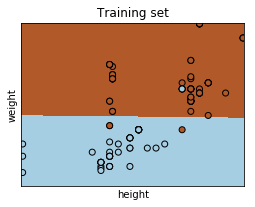

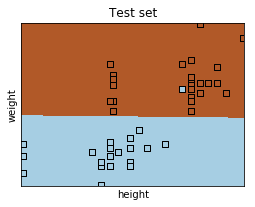

In [15]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02  # step size in the mesh
x_min, x_max = X_reduced[:, 0].min() - .5, X_reduced[:, 0].max() + .5
y_min, y_max = X_reduced[:, 1].min() - .5, X_reduced[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_training[:, 0], X_training[:, 1], c=Y_training, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Training set')

plt.show()

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Test set')

plt.show()